# Title
 

### Imports

In [332]:
import requests, time, csv
from bs4 import BeautifulSoup

import pandas as pd
import re

import itertools

import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
from collections import Counter

%matplotlib inline

plt.style.use('default')
sns.set_palette("husl")

### Scraper

In [ ]:
BATCH = 100         # docs per "page"
START = 1          # first record index (1-based on DARE)

count, start = 0, START
with open("uva_dare_v2.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["year","authors"])

    while True:
        url = (
            "https://dare.uva.nl/search"
            f"?sort=year;browse-all=yes;docsPerPage={BATCH};startDoc={start}"
        )
        r = requests.get(url, headers={"User-Agent":"uva-scraper-demo/1.0"}, timeout=30)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")

        items = soup.select("div.doctitle")
        if not items:
            print("No more results — stopping.")
            break

        for dt in items:
            text = dt.get_text(" ", strip=True)
            # authors before '(', year inside '(...)'
            if "(" in text and ")" in text:
                authors = text.split("(", 1)[0].strip()
                year = text.split("(", 1)[1].split(")", 1)[0].strip()
            else:
                authors, year = "", ""

            w.writerow([year, authors])
            count += 1

        print(f"Fetched {len(items)} at startDoc={start} — total {count}")
        start += BATCH
        time.sleep(1.2)

print(f"Done. Collected {count} records.")


### Cleaning

In [333]:
def standardise_data(df):
    """
    Standardise year format and clean author names
    """
    df_clean = df.copy()
    
    # clean year column 
    ## extract just the year part from dates like "1-10-2025"
    def extract_year(year_str):
        year_str = str(year_str)
        year_match = re.search(r'(\d{4})', year_str)
        if year_match:
            return year_match.group(1)
        
        return year_str
    
    df_clean['year'] = df_clean['year'].apply(extract_year)

    ## drop rows with invalid years 
    df_clean = df_clean[df_clean['year'].apply(lambda x: bool(re.match(r'^\d{4}$', str(x))))]
    
    # clean author names
    ## remove extra whitespace
    df_clean['authors'] = df_clean['authors'].apply(
        lambda x: re.sub(r'\s+', ' ', str(x).strip()) if pd.notna(x) else x
    )
    
    return df_clean


def remove_near_duplicates(df):
    """
    Remove near-duplicates that have same authors but might have different year formats
    """
    df_clean = df.copy()
    
    df_clean['authors_clean'] = df_clean['authors'].apply(
        lambda x: re.sub(r'[^a-zA-Z]', '', str(x).lower()) if pd.notna(x) else ''
    )
    
    # find duplicates based on cleaned authors (ignoring year differences)
    author_duplicates = df_clean[df_clean.duplicated(['authors_clean'], keep=False)]
    
    if len(author_duplicates) > 0:
        
        author_groups = author_duplicates.groupby('authors_clean')
        
        removed_count = 0
        indices_to_remove = []
        
        for authors_clean, group in author_groups:
            if len(group) > 1:                
                keep_index = group.index[0]
                remove_indices = group.index[1:]
                indices_to_remove.extend(remove_indices)
                removed_count += len(remove_indices)
        
        if indices_to_remove:
            df_clean = df_clean.drop(indices_to_remove)
    
    df_clean = df_clean.drop('authors_clean', axis=1)
    
    return df_clean



In [334]:
def format_authors(authors_string):
    """
    Reformats author names to SurnameN format where N is the first letter(s) of the first name.
    Also removes white spaces.
    """

    # removes anything before the last author separator
    authors_string = authors_string.replace(' & ', ', ')
    authors_string = authors_string.replace(' ...', ', ')
    parts = [part.strip() for part in authors_string.split(',')]
    
    formatted_authors = []
    i = 0
    
    while i < len(parts):
        part = parts[i]
        
        # skips empty parts
        if not part:
            i += 1
            continue
            
        # check if this part looks like a surname 
        ## no dots, or contains prefixes
        has_prefix = any(prefix in part.lower() for prefix in ['van', 'de', 'der'])
        has_dot = '.' in part
        
        if not has_dot or has_prefix:
            # this is probably a surname
            surname = part
            
            # looks for first name next to it
            initials = ""
            j = i + 1
            while j < len(parts) and ('.' in parts[j] or '-' in parts[j]):
                # extracts everything from first name part
                first_name_part = parts[j]
                for char in first_name_part:
                    if char.isupper() or char in '-.':
                        initials += char
                j += 1
            
            # cleaning and formatting
            initials = initials.replace('.', '').replace(' ', '')
            initials = initials.replace('-', '')
            
            formatted_author = surname.replace(' ', '') + initials
            formatted_authors.append(formatted_author)
            
            i = j  # skips what we've done
        else:
            # for organisations
            initials = ""
            for char in part:
                if char.isupper() or char in '-.':
                    initials += char
            initials = initials.replace('.', '').replace(' ', '').replace('-', '')
            
            if initials:
                formatted_authors.append(initials)
            i += 1
    
    return ', '.join(formatted_authors)



In [335]:
def clean(input_file, output_file):
    """
    Clean the CSV file by removing duplicate entries and standardising the data
    """
    df = pd.read_csv(input_file)
    print(f"Initial dataset: {len(df)} rows")
        
    duplicates = df[df.duplicated(keep=False)]
    
    # remove exact duplicates (same year and same authors)
    df_clean = df.drop_duplicates()
    
    # standardise year format and author names
    df_clean = standardise_data(df_clean)
    
    # remove near-duplicates
    df_clean = remove_near_duplicates(df_clean)

    # drop na rows
    df_clean = df_clean.dropna(subset=['year', 'authors'])

    # drop that one 297 year i cant seem to get rid of 
    df_clean = df_clean[df_clean['year'] != '0297']

    # format authors
    df_clean['authors'] = df_clean['authors'].apply(format_authors)

    # save
    df_clean.to_csv(output_file, index=False)
    print(f"\nCleaned data saved to: {output_file}")
    print(f"Final dataset: {len(df_clean)} rows")
    
    
    return df_clean



In [ ]:
def min_degree_filter_clean(min_degree, input_file, output_file):
    """
    Remove rows that have only one author
    """

    df = pd.read_csv(input_file)
    
    df['author_count'] = df['authors'].apply(
        lambda x: len(str(x).split(','))
    )
    
    df = df[df['author_count'] > min_degree]
    
    df = df.drop('author_count', axis=1)

    df.to_csv(output_file, index=False)
    print(f"\nCleaned filtered data saved to: {output_file}, min degree of {min_degree}")
    print(f"Final dataset: {len(df)} rows")

    return df

In [340]:
input_file = "uva_dare.csv"
output_file = "uva_dare_cleaned.csv"
output_file_min_degree = "uva_dare_cleaned_8.csv"
    
cleaned_df = clean(input_file, output_file)
df = min_degree_filter_clean(8, output_file, output_file_min_degree)

Initial dataset: 210079 rows

Cleaned data saved to: uva_dare_cleaned.csv
Final dataset: 110983 rows

Cleaned filtered data saved to: uva_dare_cleaned_8.csv, min degree of 8
Final dataset: 9416 rows


### Convert to gephi

In [342]:
# author list
authors_set = set()
for authors in df['authors']:
    author_list = [author.strip() for author in authors.split(',')]
    authors_set.update(author_list)

# nodes
nodes_df = pd.DataFrame(list(authors_set), columns=['Id'])
nodes_df['Label'] = nodes_df['Id']

# pairwise edges
edges = []
for _, row in df.iterrows():
    if pd.notna(row['authors']):
        authors = [author.strip() for author in row['authors'].split(',')]
        year = row['year']
        
        for author1, author2 in itertools.combinations(authors, 2):
            u, v = (author1, author2) if author1 < author2 else (author2, author1)
            edges.append({
                'Source': u,
                'Target': v,
                'Year': year,
                'Weight': 1,  
                'Type': 'Undirected'
            })
            

edges_df = pd.DataFrame(edges)

# Aggregate repeated collaborations
agg = (edges_df
       .groupby(["Source","Target"], as_index=False)
       .agg(Weight=("Year","count"),
            FirstYear=("Year","min"),
            LastYear=("Year","max")))

nodes_df.to_csv('nodes_8.csv', index=False)
agg.to_csv('edges_8.csv', index=False)


### Assignment 1

In [343]:
# Build G
G = nx.Graph()
G.add_weighted_edges_from((r.Source, r.Target, int(r.Weight)) for r in agg.itertuples(index=False))

# Largest connected component for path-based metrics
if G.number_of_nodes() > 0:
    lcc_nodes = max(nx.connected_components(G), key=len)
    Gcc = G.subgraph(lcc_nodes).copy()
else:
    Gcc = G


print(f"Created NetworkX graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Created NetworkX graph with 57343 nodes and 591464 edges


### Network summary


In [346]:
def network_summary(G, df):
    """
    Print a summary of the network properties.
    
    Args:
        G (networkx.Graph): Network graph
        df (pandas.DataFrame): Original data
    """
    print(f"\n{'='*60}")
    print("NETWORK SUMMARY")
    print(f"{'='*60}")
    
    print(f"Number of authors (nodes): {G.number_of_nodes()}")
    print(f"Number of co-author pairs (edges): {len(df)}")
    
    # Connected components
    num_components = nx.number_connected_components(G)
    largest_cc_size = len(max(nx.connected_components(G), key=len))
    
    print(f"Number of connected components: {num_components}")
    print(f"Size of largest connected component: {largest_cc_size}")
    print(f"Percentage in largest component: {largest_cc_size/G.number_of_nodes()*100:.1f}%")
    
    # Density
    density = nx.density(G)
    print(f"Network density: {density:.6f}")
    
    # Average clustering coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")

In [347]:
network_summary(G, agg)


NETWORK SUMMARY
Number of authors (nodes): 57343
Number of co-author pairs (edges): 591464
Number of connected components: 121
Size of largest connected component: 55700
Percentage in largest component: 97.1%
Network density: 0.000360
Average clustering coefficient: 0.8741


### Degree distribution

In [348]:
def plot_degree_distribution(G):
    """
    Plot the degree distribution of the network for authors with at least 1 co-author.
    
    Args:
        G (networkx.Graph): Network graph
    """
    print("Plotting degree distribution...")
    
    # Get degree sequence
    degrees = [G.degree(n) for n in G.nodes() if G.degree(n) >= 1]
    degree_counts = Counter(degrees)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale plot
    degrees_list = list(degree_counts.keys())
    counts_list = list(degree_counts.values())
    
    ax1.bar(degrees_list, counts_list, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Degree (≥ 1)')
    ax1.set_ylabel('Number of Authors')
    ax1.set_title('Degree Distribution (Linear Scale)')
    ax1.grid(True, alpha=0.3)
    
    # Log-log scale plot
    ax2.loglog(degrees_list, counts_list, 'bo', alpha=0.7, markersize=4)
    ax2.set_xlabel('Degree (≥ 1, log scale)')
    ax2.set_ylabel('Number of Authors (log scale)')
    ax2.set_title('Degree Distribution (Log-Log Scale)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('degree_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print basic statistics
    print(f"\nDegree Distribution Statistics:")
    print(f"Number of authors with co-authors: {len(degrees)}")
    print(f"Mean degree: {np.mean(degrees):.2f}")
    print(f"Median degree: {np.median(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")
    print(f"Standard deviation: {np.std(degrees):.2f}")


Plotting degree distribution...


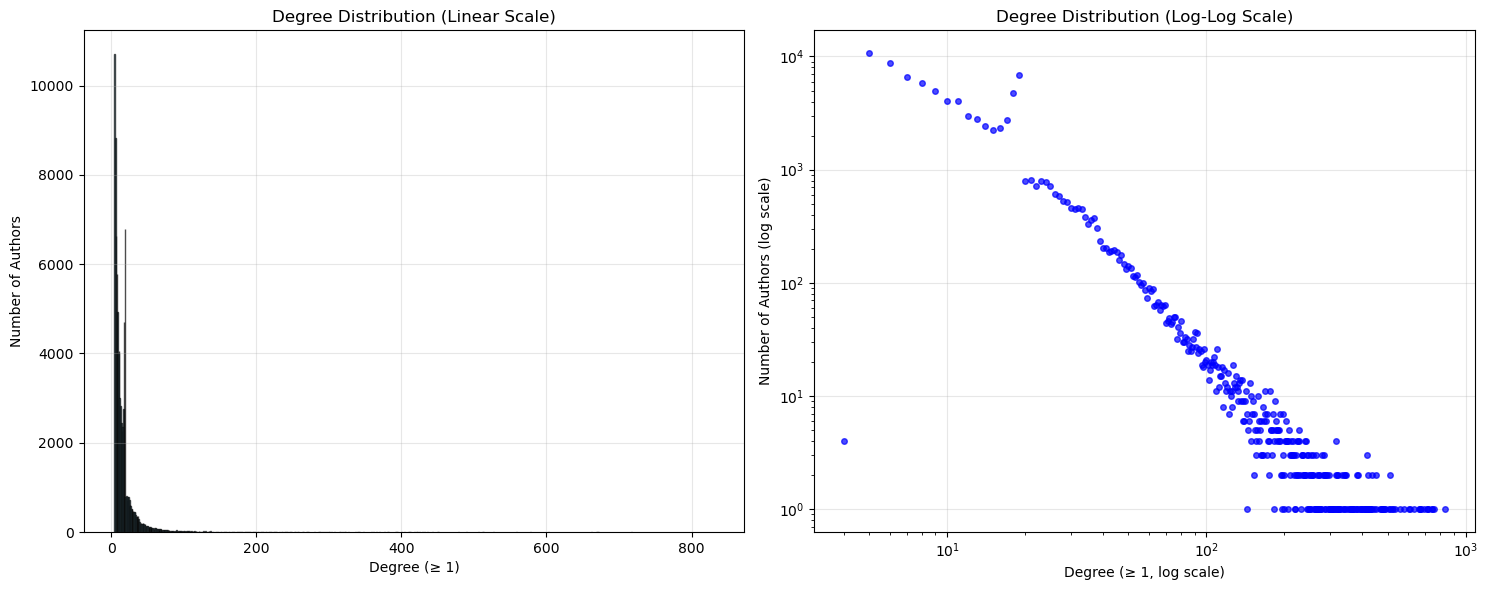


Degree Distribution Statistics:
Number of authors with co-authors: 88512
Mean degree: 17.42
Median degree: 11.00
Max degree: 831
Min degree: 4
Standard deviation: 25.78


In [326]:
plot_degree_distribution(G)

### Centrality Analysis

In [ ]:
def calculate_centrality_measures(G):
    """
    Calculate various centrality measures for the network.
    
    Args:
        G (networkx.Graph): Network graph
        
    Returns:
        dict: Dictionary containing centrality measures
    """
    print("Calculating centrality measures...")
    
    centralities = {}
    
    # Degree centrality
    print("  - Degree centrality...")
    centralities['degree'] = nx.degree_centrality(G)
    
    # Betweenness centrality (using sampling for large networks)
    print("  - Betweenness centrality...")
    if G.number_of_nodes() > 1000:
        # Use sampling for large networks to speed up computation
        k = min(1000, G.number_of_nodes())
        centralities['betweenness'] = nx.betweenness_centrality(G, k=k)
        print(f"    (using sampling with k={k} nodes)")
    else:
        centralities['betweenness'] = nx.betweenness_centrality(G)
    
    # Closeness centrality
    print("  - Closeness centrality...")
    # Only calculate for the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc)
    closeness_largest = nx.closeness_centrality(G_largest)
    
    # Extend to full graph with 0 for disconnected nodes
    centralities['closeness'] = {node: closeness_largest.get(node, 0) for node in G.nodes()}
    
    # Eigenvector centrality
    print("  - Eigenvector centrality...")
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G_largest, max_iter=1000)
        # Extend to full graph with 0 for disconnected nodes
        centralities['eigenvector'] = {node: centralities['eigenvector'].get(node, 0) for node in G.nodes()}
    except nx.PowerIterationFailedConvergence:
        print("    Warning: Eigenvector centrality failed to converge, using PageRank instead")
        centralities['eigenvector'] = nx.pagerank(G)
    
    return centralities

Network too large (57343 nodes), sampling to 5000 nodes...
Sampled network: 5000 nodes, 54167 edges


In [352]:
centralities = calculate_centrality_measures(G)

Calculating centrality measures...
  - Degree centrality...
  - Betweenness centrality...
    (using sampling with k=1000 nodes)
  - Closeness centrality...
    (using approximate closeness)
  - Eigenvector centrality...
    Using PageRank instead: Largest component too large for eigenvector
  - PageRank...


In [354]:
def display_top_authors(centralities, top_n=10):
    """
    Display top N authors for each centrality measure.
    
    Args:
        centralities (dict): Dictionary of centrality measures
        top_n (int): Number of top authors to display
    """
    print(f"\n{'='*60}")
    print(f"TOP {top_n} AUTHORS BY CENTRALITY MEASURES")
    print(f"{'='*60}")
    
    for measure_name, measure_values in centralities.items():
        print(f"\n{measure_name.upper()} CENTRALITY:")
        print("-" * 40)
        
        # Sort authors by centrality value
        sorted_authors = sorted(measure_values.items(), key=lambda x: x[1], reverse=True)
        
        for i, (author, value) in enumerate(sorted_authors[:top_n], 1):
            print(f"{i:2d}. {author:4s} - {value:.6f}")

In [355]:
display_top_authors(centralities, top_n=10)


TOP 10 AUTHORS BY CENTRALITY MEASURES

DEGREE CENTRALITY:
----------------------------------------
 1. HesselsJWT - 0.063813
 2. WijersRAMJ - 0.059212
 3. KouveliotouC - 0.058412
 4. vanderHorstAJ - 0.054211
 5. WijnandsR - 0.054011
 6. DominikC - 0.054011
 7. AltamiranoD - 0.049610
 8. KaperL - 0.049410
 9. DegenaarN - 0.048810
10. MarkoffS - 0.047810

BETWEENNESS CENTRALITY:
----------------------------------------
 1. LiJ  - 0.031004
 2. WangY - 0.027579
 3. WangX - 0.026716
 4. ZhangY - 0.024450
 5. ChenY - 0.020218
 6. LiY  - 0.019019
 7. WangJ - 0.018884
 8. LucassenPJ - 0.018488
 9. AaronsonNK - 0.018416
10. ZhangL - 0.018352

CLOSENESS CENTRALITY:
----------------------------------------
 1. PoldermansD - 1.000000
 2. StengleinS - 1.000000
 3. FlanneryDB - 1.000000
 4. JacquesJ - 1.000000
 5. WoodBrooksA - 1.000000
 6. ItoA - 1.000000
 7. DrawzeskiK - 1.000000
 8. SpreeuwRJC - 1.000000
 9. KallanseeP - 1.000000
10. ArnokourosG - 1.000000

EIGENVECTOR CENTRALITY:
--------------

In [363]:
centralities.keys()

dict_keys(['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank'])

IndexError: index 4 is out of bounds for axis 0 with size 4

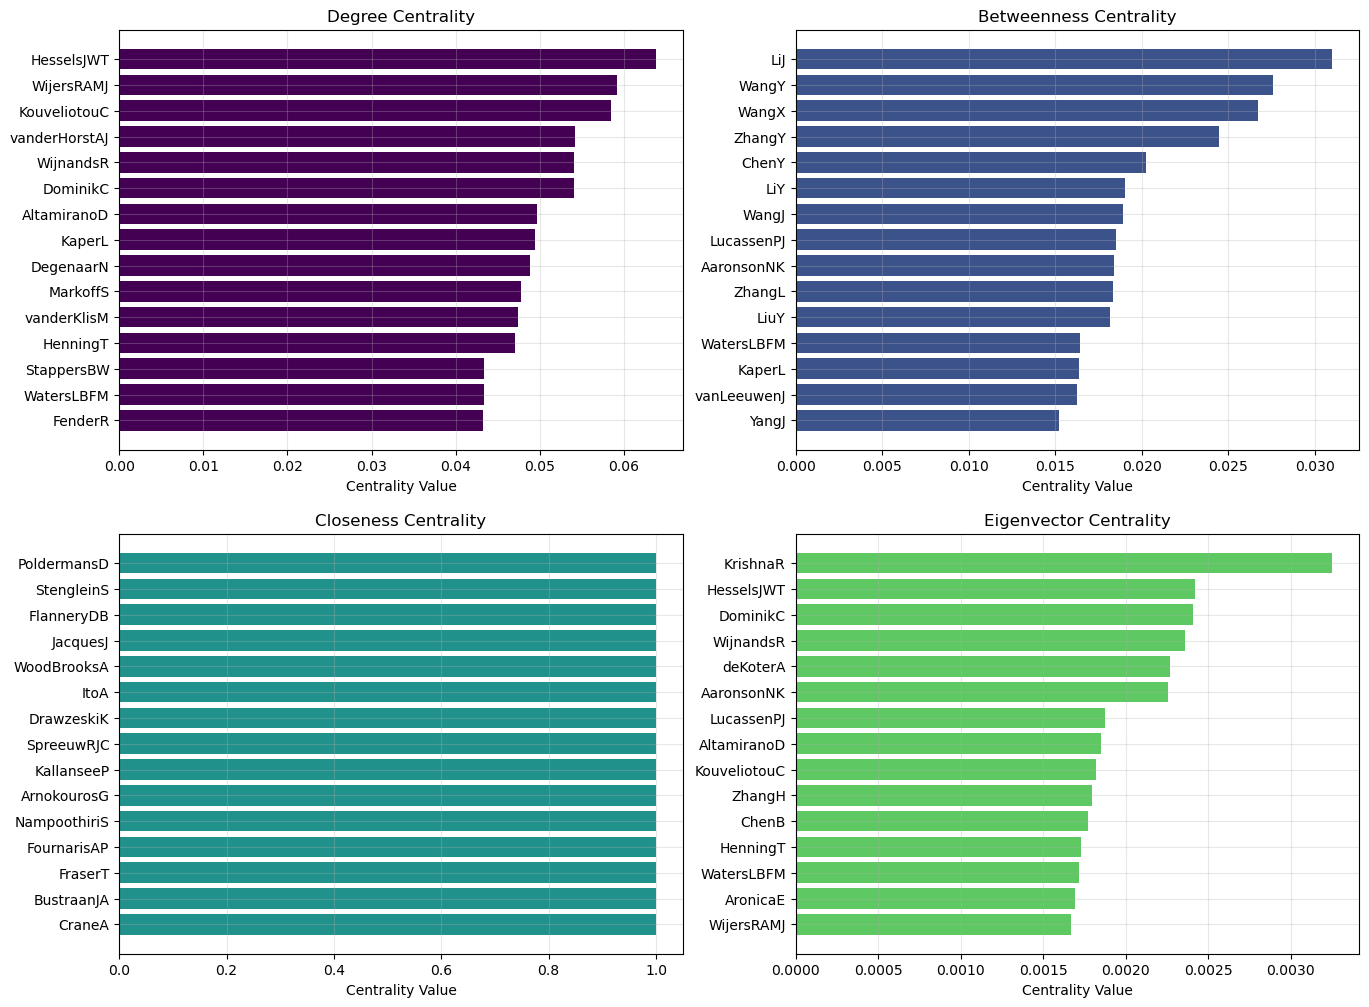

In [364]:
# Create a comparison plot of different centrality measures for top authors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

centrality_names = ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank']
centrality_titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'PageRank Centrality']

for i, (name, title) in enumerate(zip(centrality_names, centrality_titles)):
    # Get top 15 authors for this centrality measure
    sorted_authors = sorted(centralities[name].items(), key=lambda x: x[1], reverse=True)[:15]
    names = [item[0] for item in sorted_authors]
    values = [item[1] for item in sorted_authors]
    
    # Create horizontal bar plot
    axes[i].barh(range(len(names)), values, color=plt.cm.viridis(i/4))
    axes[i].set_yticks(range(len(names)))
    axes[i].set_yticklabels(names)
    axes[i].set_xlabel('Centrality Value')
    axes[i].set_title(title)
    axes[i].grid(True, alpha=0.3)
    
    # Invert y-axis to show highest values at top
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('centrality_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [368]:
rng = np.random.default_rng(42)

def basic_stats(H: nx.Graph, sample_apl: int | None = 500) -> dict:
    N, E = H.number_of_nodes(), H.number_of_edges()
    avg_k = (2*E/N) if N else np.nan
    dens  = nx.density(H) if N > 1 else 0.0
    # faster global clustering proxy
    Cg    = nx.transitivity(H) if N > 1 else 0.0

    # average path length: exact for small graphs, sampled BFS for large
    if N == 0:
        L = np.nan
    elif N < 5000:
        L = nx.average_shortest_path_length(H)
    else:
        # sample s sources and average their mean distances
        s = min(sample_apl, N)
        nodes = list(H)
        srcs = rng.choice(nodes, size=s, replace=False)
        dbar = []
        for u in srcs:
            lengths = nx.single_source_shortest_path_length(H, u)
            # exclude self-distance 0
            if len(lengths) > 1:
                dbar.append(np.mean([d for v, d in lengths.items() if v != u]))
        L = float(np.mean(dbar)) if dbar else np.nan

    return {"N": N, "E": E, "avg_degree": avg_k, "density": dens,
            "avg_clustering≈": Cg, "avg_path_len≈": L}

def LCC(H):
    return H.subgraph(max(nx.connected_components(H), key=len)).copy() if H.number_of_nodes() else H.copy()

# --- Real network (assumed pre-built) ---
real = basic_stats(Gcc)
N = real["N"]
k_float = real["avg_degree"]

# Save real degrees for later plots
deg_real = np.fromiter((d for _, d in Gcc.degree()), dtype=int)

display(pd.DataFrame([{"model":"Real (LCC)", **real}]).set_index("model"))


,N,E,avg_degree,density,avg_clustering≈,avg_path_len≈
model,,,,,,
Real (LCC),55700,581153,20.867253,0.000375,0.327535,4.825467


,N,E,avg_degree,density,avg_clustering≈,avg_path_len≈
model,,,,,,
Erdős–Rényi (LCC),55700,580321,20.837379,0.000374,0.000368,3.884734


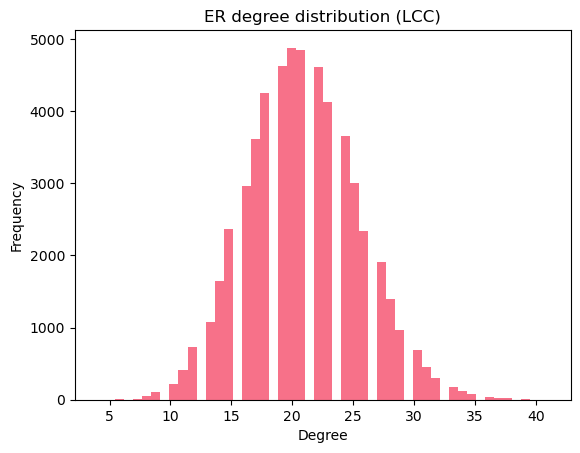

In [369]:
# ER matches expected ⟨k⟩ exactly via p = ⟨k⟩/(N−1)
p = (k_float / (N-1)) if N > 1 else 0.0
G_er = nx.fast_gnp_random_graph(N, p, seed=42)   # faster than erdos_renyi_graph
G_er_cc = LCC(G_er)

er_stats = basic_stats(G_er_cc)
deg_er = np.fromiter((d for _, d in G_er_cc.degree()), dtype=int)

display(pd.DataFrame([{"model":"Erdős–Rényi (LCC)", **er_stats}]).set_index("model"))

plt.figure()
plt.hist(deg_er, bins=50)
plt.xlabel("Degree"); plt.ylabel("Frequency"); plt.title("ER degree distribution (LCC)")
plt.show()


,N,E,avg_degree,density,avg_clustering≈,avg_path_len≈
model,,,,,,
Watts–Strogatz (LCC),55700,557000,20.0,0.000359,0.515286,5.241847


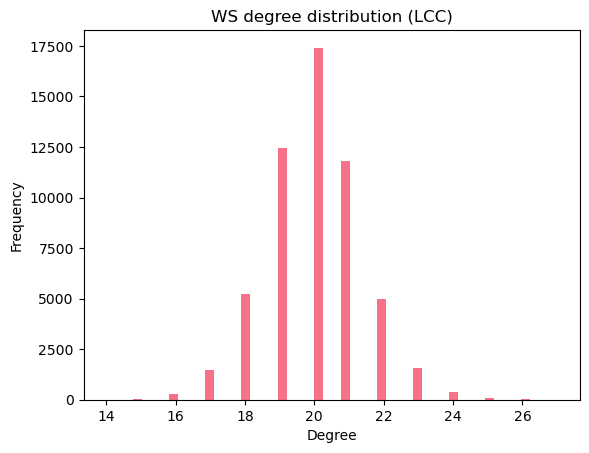

In [370]:
# WS needs an even integer k
k_int = max(2, int(round(k_float))) if not np.isnan(k_float) else 2
k_ws  = k_int if k_int % 2 == 0 else k_int - 1
k_ws  = max(2, min(k_ws, max(2, N-1)))
beta  = 0.1

G_ws = nx.watts_strogatz_graph(N, k_ws, beta, seed=42)
G_ws_cc = LCC(G_ws)

ws_stats = basic_stats(G_ws_cc)
deg_ws = np.fromiter((d for _, d in G_ws_cc.degree()), dtype=int)

display(pd.DataFrame([{"model":"Watts–Strogatz (LCC)", **ws_stats}]).set_index("model"))

plt.figure()
plt.hist(deg_ws, bins=50)
plt.xlabel("Degree"); plt.ylabel("Frequency"); plt.title("WS degree distribution (LCC)")
plt.show()


,N,E,avg_degree,density,avg_clustering≈,avg_path_len≈
model,,,,,,
Barabási–Albert (LCC),55700,556900,19.996409,0.000359,0.00243,3.516671


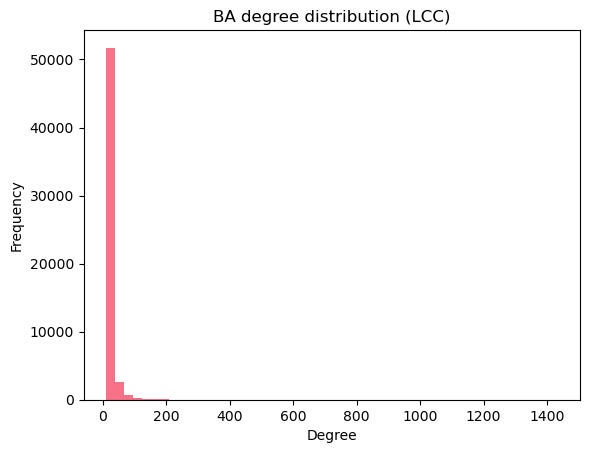

In [371]:
# BA needs integer m ≈ ⟨k⟩/2 (≥1)
m = max(1, int(round(k_int/2)))
m = min(m, max(1, N-1))

G_ba = nx.barabasi_albert_graph(N, m, seed=42)
G_ba_cc = LCC(G_ba)

ba_stats = basic_stats(G_ba_cc)
deg_ba = np.fromiter((d for _, d in G_ba_cc.degree()), dtype=int)

display(pd.DataFrame([{"model":"Barabási–Albert (LCC)", **ba_stats}]).set_index("model"))

plt.figure()
plt.hist(deg_ba, bins=50)
plt.xlabel("Degree"); plt.ylabel("Frequency"); plt.title("BA degree distribution (LCC)")
plt.show()


,N,E,avg_degree,density,avg_clustering≈,avg_path_len≈
model,,,,,,
Real (LCC),55700,581153,20.867253,0.000375,0.327535,4.825467
Erdős–Rényi (LCC),55700,580321,20.837379,0.000374,0.000368,3.884734
Watts–Strogatz (LCC),55700,557000,20.000000,0.000359,0.515286,5.241847
Barabási–Albert (LCC),55700,556900,19.996409,0.000359,0.002430,3.516671


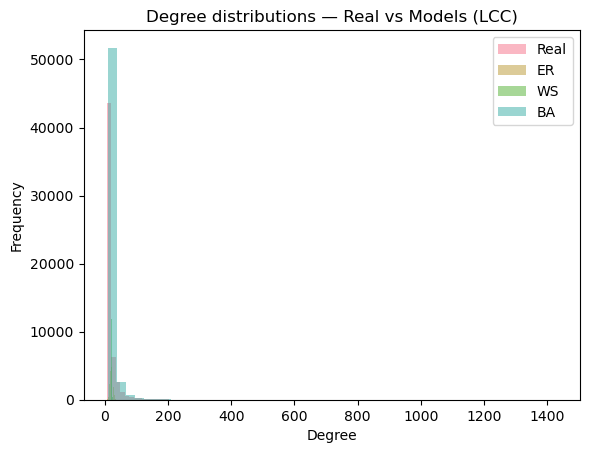

In [375]:
comp = pd.DataFrame([
    {"model":"Real (LCC)", **real},
    {"model":"Erdős–Rényi (LCC)", **er_stats},
    {"model":"Watts–Strogatz (LCC)", **ws_stats},
    {"model":"Barabási–Albert (LCC)", **ba_stats},
]).set_index("model")
display(comp)

plt.figure()
plt.hist(deg_real, bins=50, alpha=0.5, label="Real")
plt.hist(deg_er,   bins=50, alpha=0.5, label="ER")
plt.hist(deg_ws,   bins=50, alpha=0.5, label="WS")
plt.hist(deg_ba,   bins=50, alpha=0.5, label="BA")
plt.xlabel("Degree"); plt.ylabel("Frequency")
plt.title("Degree distributions — Real vs Models (LCC)")
plt.legend(); plt.show()



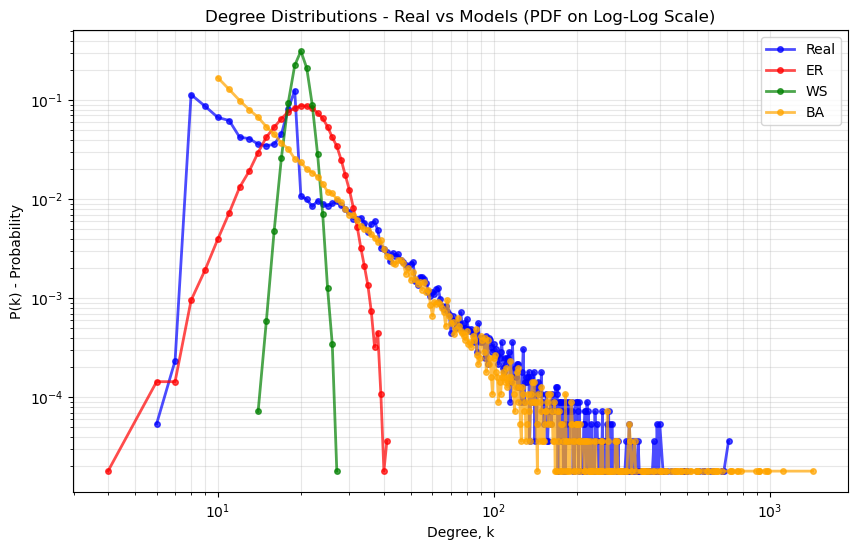

In [ ]:
plt.figure(figsize=(10, 6))

degrees_list = [deg_real, deg_er, deg_ws, deg_ba]
labels = ['Real', 'ER', 'WS', 'BA']
colors = ['blue', 'red', 'green', 'orange']

# Plot PDF on log-log scale
for degrees, label, color in zip(degrees_list, labels, colors):
    counts = Counter(degrees)
    k_values = np.array(sorted(counts.keys()))
    p_k = np.array([counts[k] / len(degrees) for k in k_values])
    
    plt.loglog(k_values, p_k, 'o-', alpha=0.7, label=label, 
               color=color, markersize=4, linewidth=2)

plt.xlabel('Degree, k')
plt.ylabel('P(k) - Probability')
plt.title('Degree Distributions - Real vs Models (PDF on Log-Log Scale)')
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

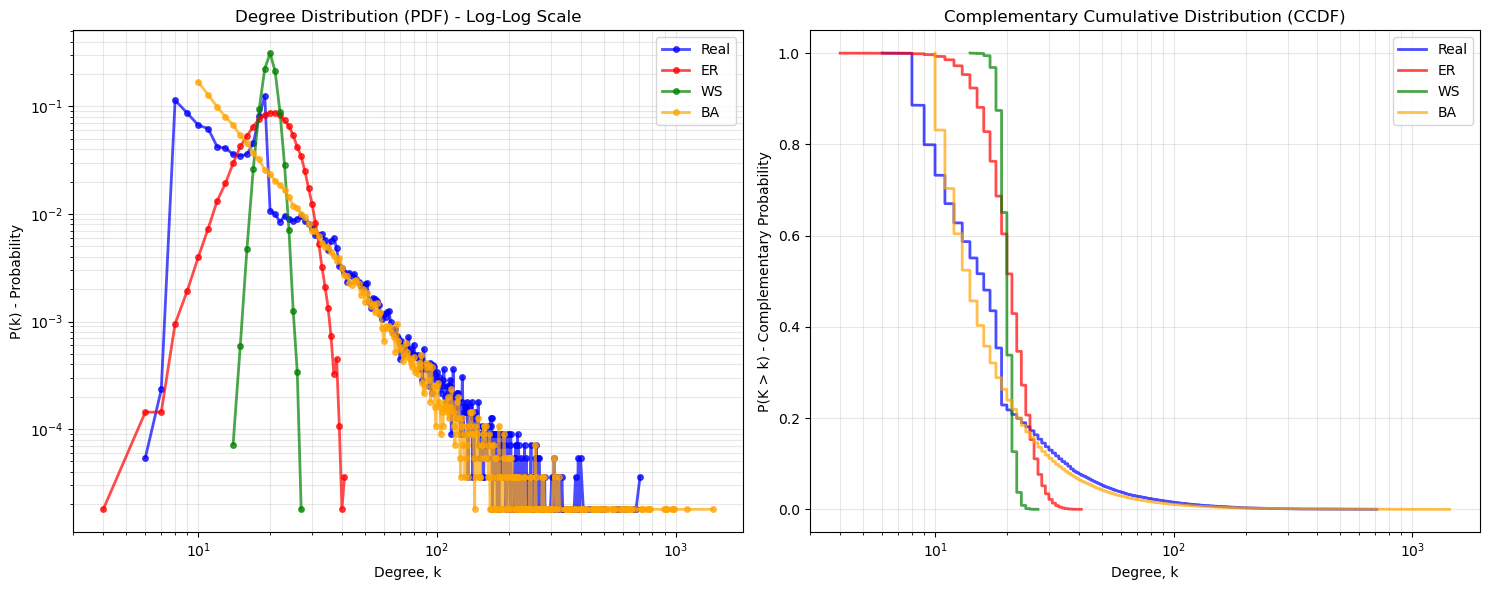

In [ ]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Prepare data
degrees_list = [deg_real, deg_er, deg_ws, deg_ba]
labels = ['Real', 'ER', 'WS', 'BA']
colors = ['blue', 'red', 'green', 'orange']



# Plot 1: Log-Log PDF (Probability Density Function)
for degrees, label, color in zip(degrees_list, labels, colors):
    # Calculate PDF
    counts = Counter(degrees)
    k_values = np.array(sorted(counts.keys()))
    p_k = np.array([counts[k] / len(degrees) for k in k_values])
    
    # Plot with points and lines
    ax1.loglog(k_values, p_k, 'o-', alpha=0.7, label=label, 
               color=color, markersize=4, linewidth=2)

ax1.set_xlabel('Degree, k')
ax1.set_ylabel('P(k) - Probability')
ax1.set_title('Degree Distribution (PDF) - Log-Log Scale')
ax1.legend()
ax1.grid(True, which="both", alpha=0.3)

# Plot 2: Log-Lin CCDF (Complementary Cumulative Distribution Function)
for degrees, label, color in zip(degrees_list, labels, colors):
    # Calculate CCDF
    sorted_degrees = np.sort(degrees)
    ccdf = 1 - (np.arange(len(sorted_degrees)) + 1) / len(sorted_degrees)
    
    # Plot
    ax2.semilogx(sorted_degrees, ccdf, label=label, 
                 color=color, alpha=0.7, linewidth=2)

ax2.set_xlabel('Degree, k')
ax2.set_ylabel('P(K > k) - Complementary Probability')
ax2.set_title('Complementary Cumulative Distribution (CCDF)')
ax2.legend()
ax2.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()